In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import plotly
import torch
import gpytorch

In [3]:
druck = weekday_time_series(sensor_id='xl106_druckmaschine_30T')

In [4]:
druck['kw'] = round(druck['kw'], 2)

In [5]:
px.line(
    x=druck.index, y=druck.kw, 
    title='entsorgung_5T',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

In [ ]:
druck.index.shape

(240,)

In [ ]:
day_range = druck.index.max() - druck.index.min()
day_range

Timedelta('4 days 23:30:00')

In [6]:
time_int_range = np.arange(0, 240*5, 5)
druck['t'] = time_int_range

#entsorgung_final = pd.DataFrame(data=entsorgung['kw'], index=entsorgung['t'])
#entsorgung_final.reset_index(inplace=True)

X = druck['t'].values
y = druck['kw'].values
n = len(X)
prop_train = 0.8
n_train = round(prop_train * n)

# Training
X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
y_train = torch.from_numpy(y[:n_train]).to(torch.float64)

# Testing
#X_test = torch.from_numpy(y[n_train:]).to(torch.float64)
X_test = torch.from_numpy(X).to(torch.float64)
y_test = torch.from_numpy(y[n_train:]).to(torch.float64)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

plt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

In [78]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_short
        )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_long
        )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.RQKernel()
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [7]:
## v2 - adding scaling parameters ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [8]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 75

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

Iter 1 , Loss = 1.274460871006964 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.2403971162365364 , Noise = 0.6444966793060303
Iter 3 , Loss = 1.205997735335867 , Noise = 0.5982130169868469
Iter 4 , Loss = 1.1713101592387363 , Noise = 0.5543672442436218
Iter 5 , Loss = 1.1362736538565315 , Noise = 0.5129232406616211
Iter 6 , Loss = 1.100767537989302 , Noise = 0.4738379120826721
Iter 7 , Loss = 1.0647826115769912 , Noise = 0.43706128001213074
Iter 8 , Loss = 1.0285012419147053 , Noise = 0.40253666043281555
Iter 9 , Loss = 0.9922500246827181 , Noise = 0.37020209431648254
Iter 10 , Loss = 0.9564314097747034 , Noise = 0.33999142050743103
Iter 11 , Loss = 0.9214813030462289 , Noise = 0.3118354082107544
Iter 12 , Loss = 0.8878392483081937 , Noise = 0.28566285967826843
Iter 13 , Loss = 0.855914332296956 , Noise = 0.2614012062549591
Iter 14 , Loss = 0.8260583170579906 , Noise = 0.2389773279428482
Iter 15 , Loss = 0.7985836307031361 , Noise = 0.21831803023815155
Iter 16 , Loss = 0.7738226470447

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

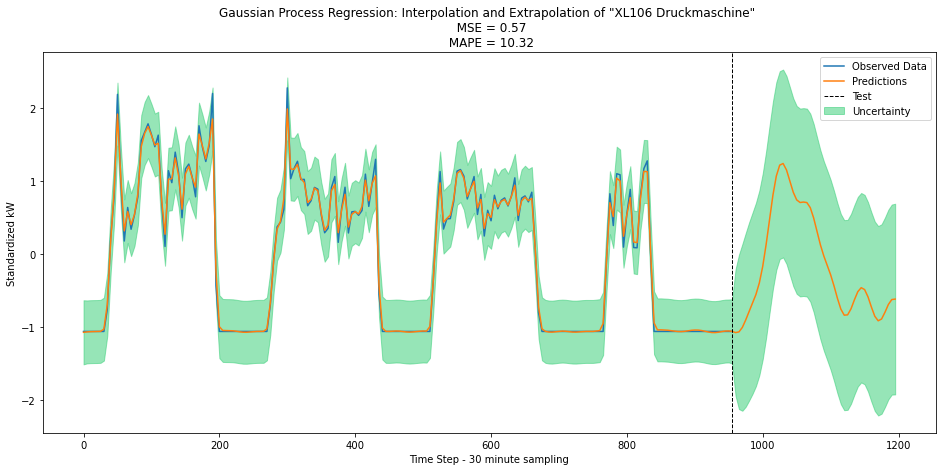

In [13]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    test_preds = observed_preds.mean[n_train:]
    mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(16, 7))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test', 'Uncertainty'])
    plt.xlabel('Time Step - 30 minute sampling')
    plt.ylabel('Standardized kW')
    plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "XL106 Druckmaschine" \n  MSE = {} \n MAPE = {}'.
    format(round(mse, 2), round(mape, 2)))
    plt.show()

In [10]:
test_preds = observed_preds.mean[n_train:]

In [11]:
mean_squared_error(y_test.numpy(), test_preds.numpy()), mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

(0.5678618004314281, 10.315731501312724)

In [11]:
observed_preds.mean

tensor([-1.0737, -1.0684, -1.0652, -1.0639, -1.0631, -1.0608, -1.0298, -0.6891,
         0.1791,  0.8528,  1.9216,  1.0260,  0.3191,  0.5851,  0.4042,  0.5436,
         0.8296,  1.4765,  1.6564,  1.7508,  1.6306,  1.4978,  1.5216,  0.7466,
         0.2723,  1.0275,  1.0344,  1.3212,  1.0742,  0.6171,  1.0994,  1.2067,
         1.0471,  0.9189,  1.6474,  1.4880,  1.3062,  1.5237,  1.8548, -0.2418,
        -0.9965, -1.0482, -1.0502, -1.0509, -1.0530, -1.0591, -1.0671, -1.0728,
        -1.0733, -1.0695, -1.0646, -1.0616, -1.0605, -1.0607, -1.0260, -0.6747,
        -0.0876,  0.3424,  0.4529,  0.7667,  1.9928,  1.1694,  1.1630,  1.2306,
         1.0360,  0.9823,  0.7085,  0.7522,  0.9063,  0.8692,  0.5578,  0.3275,
         0.3998,  0.8693,  0.9561,  0.2942,  0.6076,  0.8211,  0.3720,  0.5461,
         0.5825,  0.5504,  0.6533,  1.0151,  0.7321,  0.9729,  1.0749, -0.4278,
        -1.0151, -1.0608, -1.0616, -1.0590, -1.0561, -1.0573, -1.0627, -1.0686,
        -1.0710, -1.0686, -1.0635, -1.05